# Visualization & Creation of features

DATA Saved


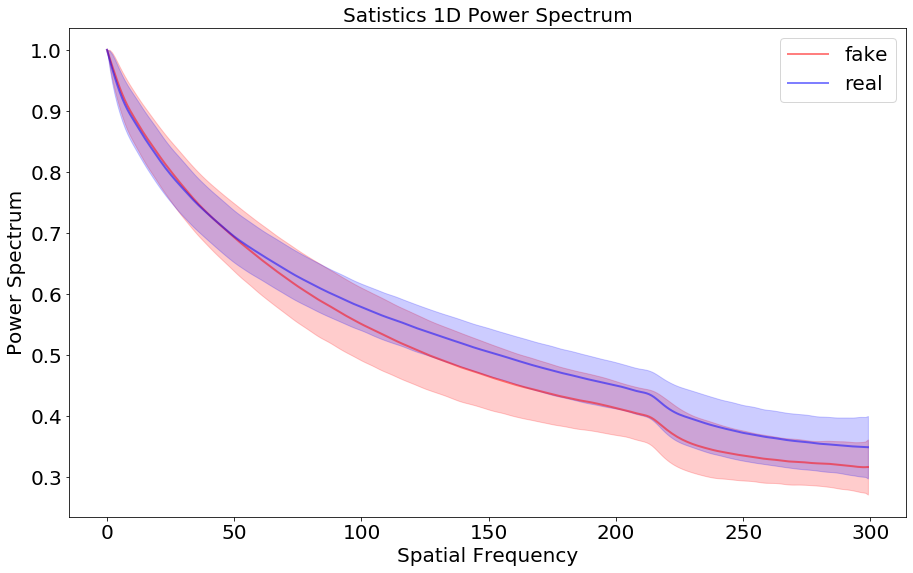

In [6]:
import cv2
import numpy as np
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

data= {}
epsilon = 1e-8
#interpolation number
N = 300
y = []
error = []
#number of samples from each type (real and deepfake)
number_iter = 900


#deepfake data
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)
rootdir = 'deepfake/'
cont = 0

for filename in glob.glob(rootdir+"*.jpg"):
    
    img = cv2.imread(filename,0)
    # Crop image to get inner face
    h = int(img.shape[0]/3)
    w = int(img.shape[1]/3)
    img = img[h:-h,w:-w]
    # Calculate FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

    # Interpolation
    points = np.linspace(0,N,num=psd1D.size) 
    xi = np.linspace(0,N,num=N) 
    interpolated = griddata(points,psd1D,xi,method='cubic')
    
    # Normalization
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 0
    cont+=1

    if cont == number_iter:
        break
    
for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])


## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)
rootdir2 = 'real/'
cont = 0

for filename in glob.glob(rootdir2+"*.jpg"):   
    
    img = cv2.imread(filename,0)
    # Crop image to get inner face
    h = int(img.shape[0]/3)
    w = int(img.shape[1]/3)
    img = img[h:-h,w:-w]
    # Calculate FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

    # Interpolation
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation
    interpolated = griddata(points,psd1D,xi,method='cubic')

    # Normalization
    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 1
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    
    
y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('croppedDeepFake_1000.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved") 


x = np.arange(0, N, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, y[0], alpha=0.5, color='red', label='fake', linewidth =2.0)
ax.fill_between(x, y[0] - error[0], y[0] + error[0], color='red', alpha=0.2)

ax.plot(x, y[1], alpha=0.5, color='blue', label='real', linewidth = 2.0)
ax.fill_between(x, y[1] - error[1], y[1] + error[1], color='blue', alpha=0.2)


ax.set_title('Satistics 1D Power Spectrum',size=20)
plt.xlabel('Spatial Frequency', fontsize=20)
plt.ylabel('Power Spectrum', fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.show()

# Classifier

In [7]:
import pandas as pd
import numpy as np
import pickle

#number of runs
num = 5
SVM = 0
LR = 0

for z in range(num):
    # read python dict back from the file
    pkl_file = open('croppedDeepFake_1000.pkl', 'rb')
    
    data = pickle.load(pkl_file)
    pkl_file.close()
    X = data["data"]
    y = data["label"]
    X.shape
    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        from sklearn.svm import SVC
        svclassifier = SVC(C=2.76, kernel='rbf', gamma=0.80)
        svclassifier.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))
        
        SVM+=svclassifier.score(X_train, y_train)
        LR+=logreg.score(X_test, y_test)
        
    except:
        num-=1
        print(num)
    

print("Average SVM: "+str(SVM/num))
print("Average LR: "+str(LR/num))

Average SVM: 0.8744444444444444
Average LR: 0.7955555555555556
